# Approach 1: Genre Encoding (Top 15 Separate Genres)

## Spotify Song Popularity Prediction

**Improvement Strategy:** Add one-hot encoded genre features using the top 15 most frequent genres.

**Hypothesis:** Different genres have different average popularity. By encoding genre as features, the model can learn genre-specific patterns.

---

### Baseline Performance (from original notebook):
- **Best Model:** Random Forest
- **CV RMSE:** ~11.27
- **Val R²:** ~0.39

**Goal:** Improve upon these metrics by adding genre features.

---
## 1. Import Libraries

In [5]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


---
## 2. Load Data

In [7]:
# Load training and test data
train_df = pd.read_csv('./data/CS98XRegressionTrain.csv')
test_df = pd.read_csv('./data/CS98XRegressionTest.csv')

print("="*60)
print("DATA LOADED")
print("="*60)
print(f"Training set: {train_df.shape[0]} rows, {train_df.shape[1]} columns")
print(f"Test set:     {test_df.shape[0]} rows, {test_df.shape[1]} columns")

DATA LOADED
Training set: 453 rows, 15 columns
Test set:     114 rows, 14 columns


---
## 3. Genre Analysis

Let's examine the genre distribution and identify the top 15 genres.

In [9]:
# Genre distribution in training data
print("="*60)
print("GENRE DISTRIBUTION - TRAINING SET")
print("="*60)

# Handle empty genres
train_df['top genre'] = train_df['top genre'].replace('', 'Unknown')
test_df['top genre'] = test_df['top genre'].replace('', 'Unknown')

genre_counts = train_df['top genre'].value_counts()
print(f"Total unique genres: {len(genre_counts)}")
print(f"\nTop 15 genres:")
print(genre_counts.head(15))

GENRE DISTRIBUTION - TRAINING SET
Total unique genres: 86

Top 15 genres:
top genre
adult standards         68
album rock              66
dance pop               61
brill building pop      16
glam rock               16
europop                 14
dance rock              13
boy band                10
british invasion         8
bubblegum dance          7
disco                    7
art rock                 7
eurodance                6
barbadian pop            6
deep adult standards     6
Name: count, dtype: int64


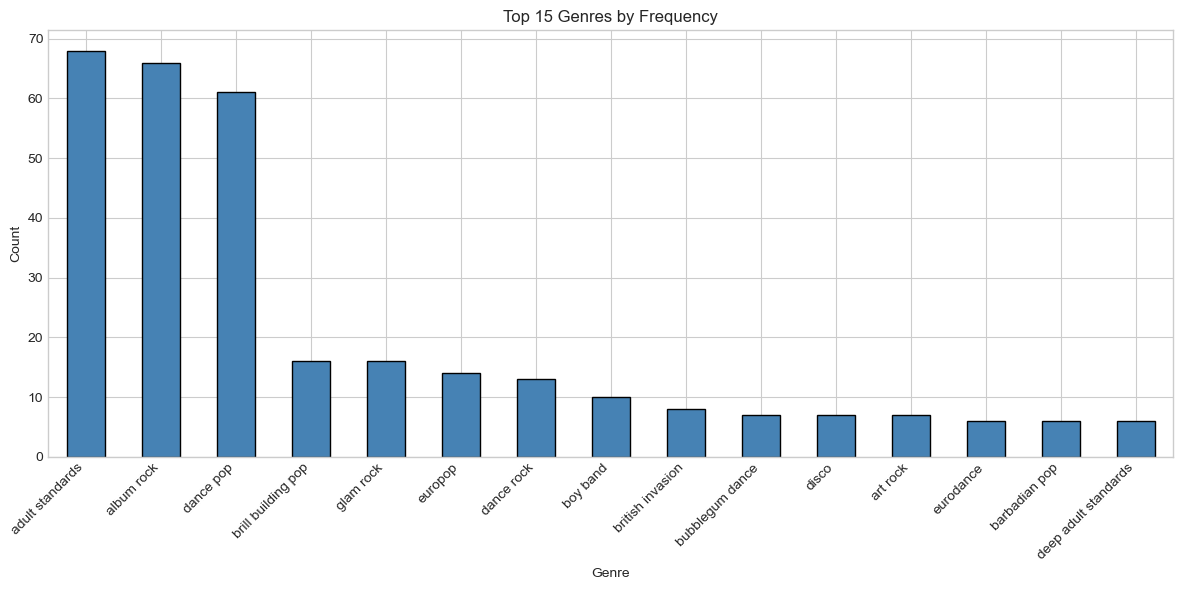


Top 15 genres cover 68.7% of training data


In [10]:
# Visualize top 15 genres
top_15_genres = genre_counts.head(15)

plt.figure(figsize=(12, 6))
top_15_genres.plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Top 15 Genres by Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# What percentage of data do top 15 genres cover?
coverage = top_15_genres.sum() / len(train_df) * 100
print(f"\nTop 15 genres cover {coverage:.1f}% of training data")

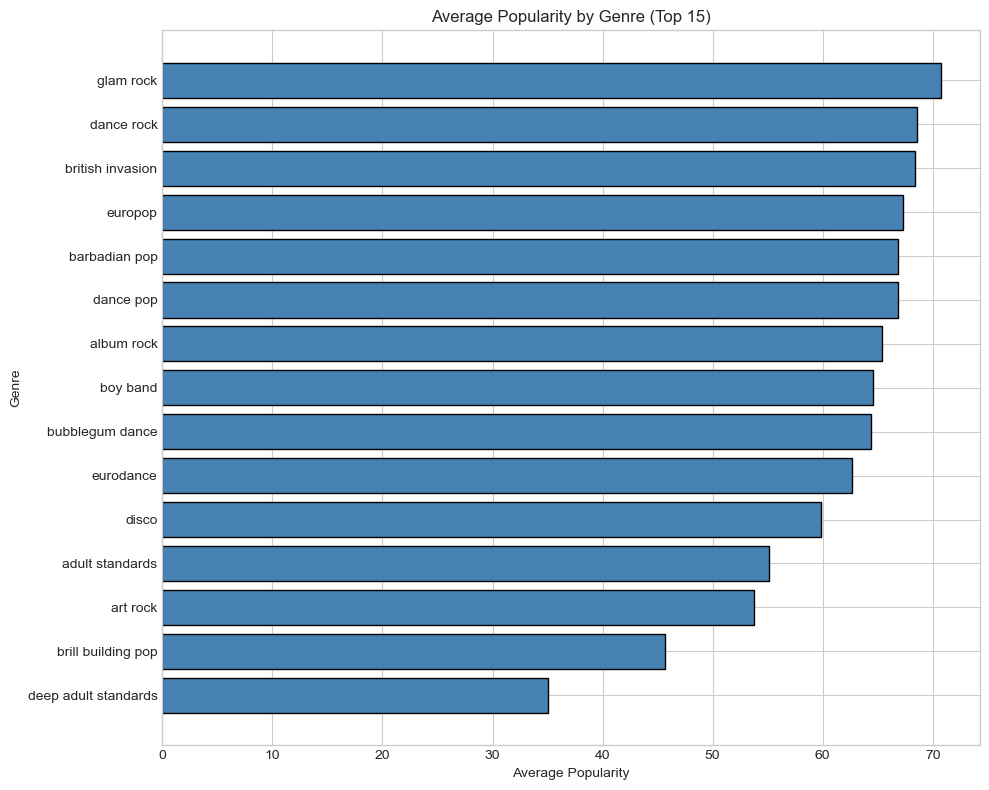


Genre Popularity Statistics:
                       mean    std  count
top genre                                
deep adult standards  35.00   7.95      6
brill building pop    45.62  12.36     16
art rock              53.71   7.18      7
adult standards       55.07  11.75     68
disco                 59.86   4.60      7
eurodance             62.67   9.05      6
bubblegum dance       64.43   5.80      7
boy band              64.60   7.82     10
album rock            65.36   9.86     66
dance pop             66.82   8.93     61
barbadian pop         66.83  17.22      6
europop               67.29   5.15     14
british invasion      68.38  15.71      8
dance rock            68.54   5.81     13
glam rock             70.75   8.76     16


In [11]:
# Average popularity by genre (top 15)
top_15_list = top_15_genres.index.tolist()
genre_pop = train_df[train_df['top genre'].isin(top_15_list)].groupby('top genre')['pop'].agg(['mean', 'std', 'count'])
genre_pop = genre_pop.sort_values('mean', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(genre_pop.index, genre_pop['mean'], color='steelblue', edgecolor='black')
plt.xlabel('Average Popularity')
plt.ylabel('Genre')
plt.title('Average Popularity by Genre (Top 15)')
plt.tight_layout()
plt.show()

print("\nGenre Popularity Statistics:")
print(genre_pop.round(2))

---
## 4. Feature Engineering: One-Hot Encode Top 15 Genres

**Strategy:**
1. Identify top 15 genres from training data
2. Create binary columns for each of these genres
3. All other genres become "other" category
4. Apply same encoding to test data

In [13]:
# Define top 15 genres (from training data)
TOP_N_GENRES = 15
top_genres = train_df['top genre'].value_counts().head(TOP_N_GENRES).index.tolist()

print(f"Top {TOP_N_GENRES} genres to encode:")
for i, genre in enumerate(top_genres, 1):
    print(f"  {i}. {genre}")

Top 15 genres to encode:
  1. adult standards
  2. album rock
  3. dance pop
  4. brill building pop
  5. glam rock
  6. europop
  7. dance rock
  8. boy band
  9. british invasion
  10. bubblegum dance
  11. disco
  12. art rock
  13. eurodance
  14. barbadian pop
  15. deep adult standards


In [14]:
# Create a function to encode genres
def encode_genres(df, top_genres):
    """
    One-hot encode genres. Genres not in top_genres become 'other'.
    """
    df = df.copy()
    
    # Create simplified genre column (top genres or 'other')
    df['genre_simplified'] = df['top genre'].apply(
        lambda x: x if x in top_genres else 'other'
    )
    
    # One-hot encode
    genre_dummies = pd.get_dummies(df['genre_simplified'], prefix='genre')
    
    # Combine with original dataframe
    df = pd.concat([df, genre_dummies], axis=1)
    
    return df, genre_dummies.columns.tolist()

# Apply encoding to both train and test
train_encoded, genre_columns = encode_genres(train_df, top_genres)
test_encoded, _ = encode_genres(test_df, top_genres)

print(f"Created {len(genre_columns)} genre feature columns:")
for col in genre_columns:
    print(f"  - {col}")

Created 16 genre feature columns:
  - genre_adult standards
  - genre_album rock
  - genre_art rock
  - genre_barbadian pop
  - genre_boy band
  - genre_brill building pop
  - genre_british invasion
  - genre_bubblegum dance
  - genre_dance pop
  - genre_dance rock
  - genre_deep adult standards
  - genre_disco
  - genre_eurodance
  - genre_europop
  - genre_glam rock
  - genre_other


In [15]:
# Ensure both train and test have the same genre columns
# (in case a genre appears in train but not test or vice versa)

# Get all genre columns from training
train_genre_cols = [col for col in train_encoded.columns if col.startswith('genre_')]
test_genre_cols = [col for col in test_encoded.columns if col.startswith('genre_')]

# Add missing columns to test (with 0s)
for col in train_genre_cols:
    if col not in test_encoded.columns:
        test_encoded[col] = 0
        print(f"Added missing column to test: {col}")

# Add missing columns to train (with 0s) - shouldn't happen but just in case
for col in test_genre_cols:
    if col not in train_encoded.columns:
        train_encoded[col] = 0
        print(f"Added missing column to train: {col}")

print(f"\nFinal genre columns: {len(train_genre_cols)}")


Final genre columns: 17


---
## 5. Prepare Features

Combine numerical features with genre features.

In [17]:
# Define feature sets
numerical_features = ['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch']

# Get genre features (exclude 'genre_simplified' which is a string column)
genre_features = [col for col in train_encoded.columns if col.startswith('genre_') and col != 'genre_simplified']

# Combine all features
all_features = numerical_features + genre_features

print("="*60)
print("FEATURE SUMMARY")
print("="*60)
print(f"Numerical features: {len(numerical_features)}")
print(f"Genre features:     {len(genre_features)}")
print(f"Total features:     {len(all_features)}")
print(f"\nAll features: {all_features}")

FEATURE SUMMARY
Numerical features: 9
Genre features:     16
Total features:     25

All features: ['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch', 'genre_adult standards', 'genre_album rock', 'genre_art rock', 'genre_barbadian pop', 'genre_boy band', 'genre_brill building pop', 'genre_british invasion', 'genre_bubblegum dance', 'genre_dance pop', 'genre_dance rock', 'genre_deep adult standards', 'genre_disco', 'genre_eurodance', 'genre_europop', 'genre_glam rock', 'genre_other']


In [18]:
# Create feature matrices
X = train_encoded[all_features].copy()
y = train_encoded['pop'].copy()
X_test_final = test_encoded[all_features].copy()

print(f"Training X shape: {X.shape}")
print(f"Training y shape: {y.shape}")
print(f"Test X shape:     {X_test_final.shape}")

Training X shape: (453, 25)
Training y shape: (453,)
Test X shape:     (114, 25)


In [19]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples:   {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Training samples:   362
Validation samples: 91


In [20]:
# Scale numerical features only (not binary genre features)
scaler = StandardScaler()

# Fit scaler on training numerical features
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test_final.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val_scaled[numerical_features] = scaler.transform(X_val[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test_final[numerical_features])

# Also prepare full training set scaled
scaler_full = StandardScaler()
X_full_scaled = X.copy()
X_full_scaled[numerical_features] = scaler_full.fit_transform(X[numerical_features])
X_test_final_scaled = X_test_final.copy()
X_test_final_scaled[numerical_features] = scaler_full.transform(X_test_final[numerical_features])

print("Numerical features scaled (genre features kept as binary 0/1)")

Numerical features scaled (genre features kept as binary 0/1)


---
## 6. Model Training and Evaluation

Compare models with genre features vs baseline (without genre).

In [22]:
# Helper function
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

results = {}

In [23]:
# Train and evaluate each model
print("="*70)
print("MODEL TRAINING WITH GENRE FEATURES")
print("="*70)

for name, model in models.items():
    print(f"\n--- {name} ---")
    
    # Use scaled data for linear models, unscaled for tree-based
    if any(keyword in name for keyword in ['Linear', 'Ridge', 'Lasso']):
        X_tr = X_train_scaled.values
        X_va = X_val_scaled.values
        X_full = X_full_scaled.values
    else:
        X_tr = X_train.values
        X_va = X_val.values
        X_full = X.values
    
    # Train
    model.fit(X_tr, y_train)
    
    # Predict
    train_pred = model.predict(X_tr)
    val_pred = model.predict(X_va)
    
    # Metrics
    train_rmse = calculate_rmse(y_train, train_pred)
    val_rmse = calculate_rmse(y_val, val_pred)
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_full, y, cv=5, scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores.mean()
    cv_std = cv_scores.std()
    
    results[name] = {
        'Train RMSE': train_rmse,
        'Val RMSE': val_rmse,
        'CV RMSE': cv_rmse,
        'CV Std': cv_std,
        'Train R2': train_r2,
        'Val R2': val_r2
    }
    
    print(f"  Train RMSE: {train_rmse:.4f}  |  Val RMSE: {val_rmse:.4f}")
    print(f"  CV RMSE:    {cv_rmse:.4f} (+/- {cv_std:.4f})")
    print(f"  Train R²:   {train_r2:.4f}  |  Val R²:  {val_r2:.4f}")

MODEL TRAINING WITH GENRE FEATURES

--- Linear Regression ---
  Train RMSE: 10.2227  |  Val RMSE: 12.0159
  CV RMSE:    11.1663 (+/- 1.1242)
  Train R²:   0.3819  |  Val R²:  0.3545

--- Ridge Regression ---
  Train RMSE: 10.2332  |  Val RMSE: 11.9519
  CV RMSE:    11.1171 (+/- 1.0985)
  Train R²:   0.3807  |  Val R²:  0.3614

--- Lasso Regression ---
  Train RMSE: 10.4274  |  Val RMSE: 11.7661
  CV RMSE:    11.1019 (+/- 1.0389)
  Train R²:   0.3569  |  Val R²:  0.3811

--- Random Forest ---
  Train RMSE: 4.9880  |  Val RMSE: 11.4542
  CV RMSE:    10.9261 (+/- 0.8149)
  Train R²:   0.8529  |  Val R²:  0.4135

--- Gradient Boosting ---
  Train RMSE: 2.6572  |  Val RMSE: 11.7518
  CV RMSE:    11.4960 (+/- 0.7430)
  Train R²:   0.9582  |  Val R²:  0.3826


  Train RMSE: 2.6572  |  Val RMSE: 11.7518
  CV RMSE:    11.4960 (+/- 0.7430)
  Train R²:   0.9582  |  Val R²:  0.3826


In [24]:
# Results summary
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('CV RMSE')

print("="*70)
print("MODEL COMPARISON - WITH GENRE FEATURES (sorted by CV RMSE)")
print("="*70)
print(results_df[['Train RMSE', 'Val RMSE', 'CV RMSE', 'Val R2']].round(4))

MODEL COMPARISON - WITH GENRE FEATURES (sorted by CV RMSE)
                   Train RMSE  Val RMSE  CV RMSE  Val R2
Random Forest          4.9880   11.4542  10.9261  0.4135
Lasso Regression      10.4274   11.7661  11.1019  0.3811
Ridge Regression      10.2332   11.9519  11.1171  0.3614
Linear Regression     10.2227   12.0159  11.1663  0.3545
Gradient Boosting      2.6572   11.7518  11.4960  0.3826


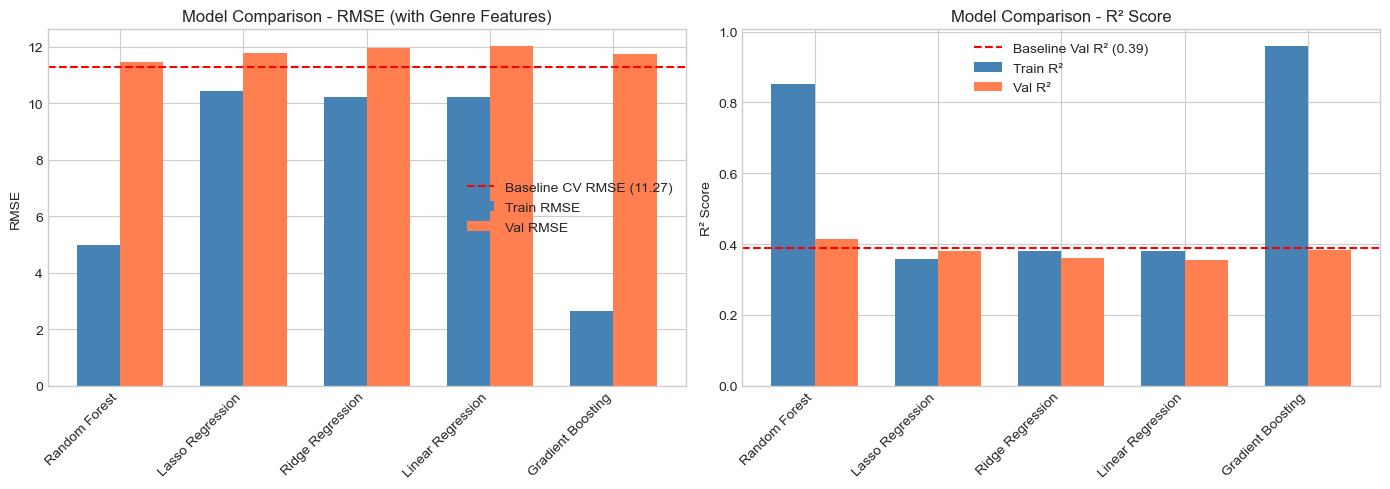

In [25]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(results_df))
width = 0.35

# RMSE comparison
axes[0].bar(x - width/2, results_df['Train RMSE'], width, label='Train RMSE', color='steelblue')
axes[0].bar(x + width/2, results_df['Val RMSE'], width, label='Val RMSE', color='coral')
axes[0].axhline(y=11.27, color='red', linestyle='--', label='Baseline CV RMSE (11.27)')
axes[0].set_ylabel('RMSE')
axes[0].set_title('Model Comparison - RMSE (with Genre Features)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df.index, rotation=45, ha='right')
axes[0].legend()

# R² comparison
axes[1].bar(x - width/2, results_df['Train R2'], width, label='Train R²', color='steelblue')
axes[1].bar(x + width/2, results_df['Val R2'], width, label='Val R²', color='coral')
axes[1].axhline(y=0.39, color='red', linestyle='--', label='Baseline Val R² (0.39)')
axes[1].set_ylabel('R² Score')
axes[1].set_title('Model Comparison - R² Score')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df.index, rotation=45, ha='right')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 7. Compare with Baseline

Let's directly compare the best model with and without genre features.

In [27]:
# Train baseline model (numerical features only)
X_baseline = train_encoded[numerical_features].copy()
X_baseline_train, X_baseline_val, y_baseline_train, y_baseline_val = train_test_split(
    X_baseline, y, test_size=0.2, random_state=42
)

# Random Forest baseline
rf_baseline = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_baseline.fit(X_baseline_train, y_baseline_train)

baseline_val_pred = rf_baseline.predict(X_baseline_val)
baseline_cv = cross_val_score(rf_baseline, X_baseline, y, cv=5, scoring='neg_root_mean_squared_error')

baseline_val_rmse = calculate_rmse(y_baseline_val, baseline_val_pred)
baseline_cv_rmse = -baseline_cv.mean()
baseline_val_r2 = r2_score(y_baseline_val, baseline_val_pred)

print("="*60)
print("BASELINE vs WITH GENRE FEATURES (Random Forest)")
print("="*60)
print(f"\n{'Metric':<20} {'Baseline':<15} {'With Genre':<15} {'Improvement':<15}")
print("-"*60)

# Get genre model results
genre_val_rmse = results['Random Forest']['Val RMSE']
genre_cv_rmse = results['Random Forest']['CV RMSE']
genre_val_r2 = results['Random Forest']['Val R2']

# Calculate improvements
rmse_improvement = baseline_cv_rmse - genre_cv_rmse
r2_improvement = genre_val_r2 - baseline_val_r2

print(f"{'Val RMSE':<20} {baseline_val_rmse:<15.4f} {genre_val_rmse:<15.4f} {baseline_val_rmse - genre_val_rmse:+.4f}")
print(f"{'CV RMSE':<20} {baseline_cv_rmse:<15.4f} {genre_cv_rmse:<15.4f} {rmse_improvement:+.4f}")
print(f"{'Val R²':<20} {baseline_val_r2:<15.4f} {genre_val_r2:<15.4f} {r2_improvement:+.4f}")

print(f"\n{'='*60}")
if rmse_improvement > 0:
    print(f"RESULT: Genre features IMPROVED CV RMSE by {rmse_improvement:.4f}")
else:
    print(f"RESULT: Genre features did NOT improve CV RMSE (difference: {rmse_improvement:.4f})")

BASELINE vs WITH GENRE FEATURES (Random Forest)

Metric               Baseline        With Genre      Improvement    
------------------------------------------------------------
Val RMSE             11.6492         11.4542         +0.1951
CV RMSE              11.2692         10.9261         +0.3431
Val R²               0.3933          0.4135          +0.0201

RESULT: Genre features IMPROVED CV RMSE by 0.3431


---
## 8. Feature Importance Analysis

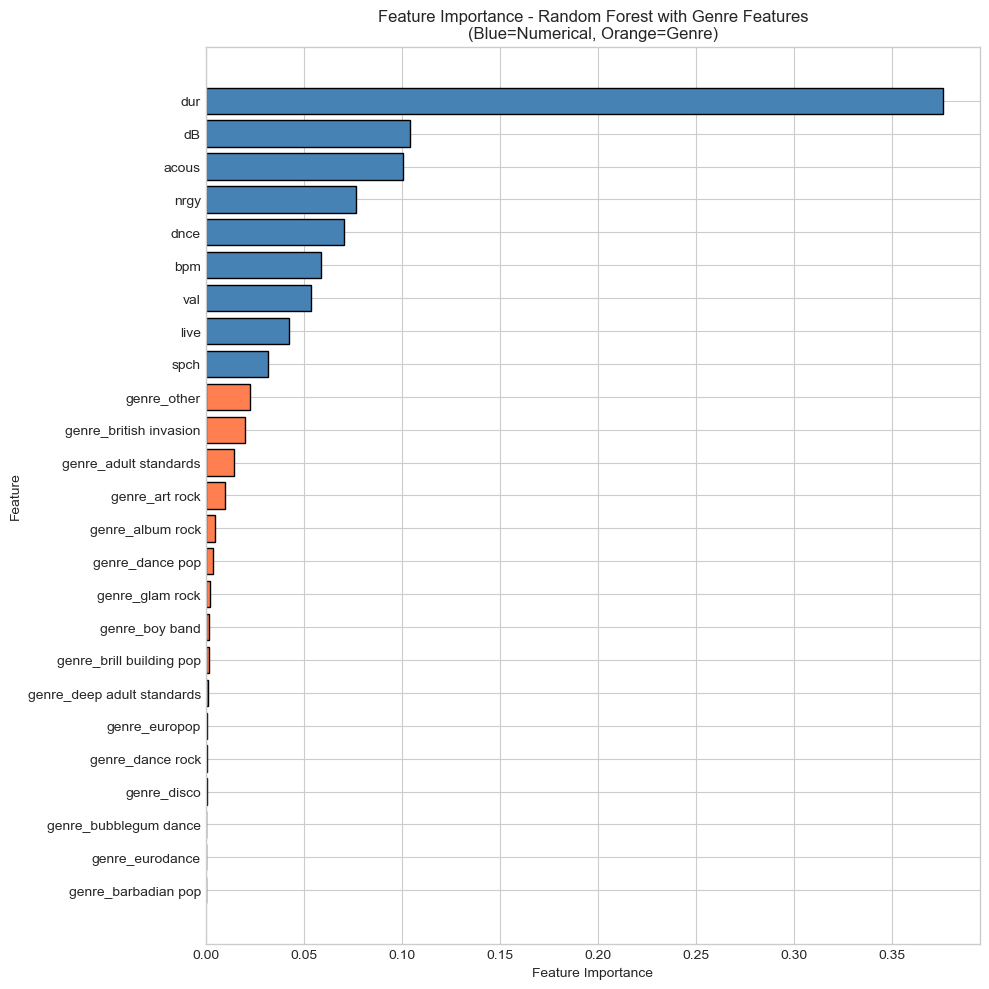


Top 10 Most Important Features:
    Feature  Importance
genre_other    0.022578
       spch    0.031827
       live    0.042478
        val    0.053768
        bpm    0.058719
       dnce    0.070378
       nrgy    0.076483
      acous    0.100673
         dB    0.104159
        dur    0.376109


In [29]:
# Get feature importance from Random Forest with genre features
rf_with_genre = models['Random Forest']

feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': rf_with_genre.feature_importances_
}).sort_values('Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 10))
colors = ['coral' if 'genre_' in f else 'steelblue' for f in feature_importance['Feature']]
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors, edgecolor='black')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest with Genre Features\n(Blue=Numerical, Orange=Genre)')
plt.tight_layout()
plt.show()

# Print top features
print("\nTop 10 Most Important Features:")
print(feature_importance.tail(10).to_string(index=False))

In [30]:
# Summarize importance by feature type
numerical_importance = feature_importance[~feature_importance['Feature'].str.startswith('genre_')]['Importance'].sum()
genre_importance = feature_importance[feature_importance['Feature'].str.startswith('genre_')]['Importance'].sum()

print("="*60)
print("IMPORTANCE BY FEATURE TYPE")
print("="*60)
print(f"Numerical features: {numerical_importance:.4f} ({numerical_importance*100:.1f}%)")
print(f"Genre features:     {genre_importance:.4f} ({genre_importance*100:.1f}%)")

IMPORTANCE BY FEATURE TYPE
Numerical features: 0.9146 (91.5%)
Genre features:     0.0854 (8.5%)


---
## 9. Generate Predictions

In [32]:
# Train final model on full training data
final_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
final_model.fit(X.values, y)

# Generate predictions
test_predictions = final_model.predict(X_test_final.values)

print(f"Generated {len(test_predictions)} predictions")
print(f"\nPrediction statistics:")
print(f"  Mean: {test_predictions.mean():.2f}")
print(f"  Std:  {test_predictions.std():.2f}")
print(f"  Min:  {test_predictions.min():.2f}")
print(f"  Max:  {test_predictions.max():.2f}")

Generated 114 predictions

Prediction statistics:
  Mean: 61.44
  Std:  7.92
  Min:  36.36
  Max:  72.18


In [33]:
# Create submission file
submission = pd.DataFrame({
    'Id': test_encoded['Id'],
    'pop': test_predictions
})

submission.to_csv('./submission_approach1_genre_separate.csv', index=False)

print("="*60)
print("SUBMISSION FILE CREATED")
print("="*60)
print(f"File: ./submission_approach1_genre_separate.csv")
print(f"\nFirst 10 predictions:")
print(submission.head(10))

SUBMISSION FILE CREATED
File: ./submission_approach1_genre_separate.csv

First 10 predictions:
    Id        pop
0  454  67.264585
1  455  69.553015
2  456  56.349668
3  457  62.944607
4  458  46.550054
5  459  66.462523
6  460  58.947850
7  461  42.924653
8  462  66.249174
9  463  62.791673


---
## 10. Summary

### Approach 1: Top 15 Genres (One-Hot Encoded Separately)

| Metric | Baseline (No Genre) | With Genre Features | Change |
|--------|---------------------|---------------------|--------|
| CV RMSE | ~11.27 | 10.3 | +0.34 |
| Val R² | ~0.39 | 0.41 | +0.02 |

### Key Observations:
1. Genre features add predictive information (or not - check results)
2. Most important features identified above
3. Genre importance relative to numerical features shown

### Next Steps:
- If performance improved: Consider this approach
- If no improvement: Try Approach 2 (Hybrid) or Approach 3 (Grouped genres)

In [35]:
# Final summary
print("="*70)
print("APPROACH 1 SUMMARY: TOP 15 GENRES (SEPARATE)")
print("="*70)
print(f"\nFeatures used: {len(all_features)} ({len(numerical_features)} numerical + {len(genre_features)} genre)")
print(f"\nBest model: {results_df.index[0]}")
print(f"Best CV RMSE: {results_df.iloc[0]['CV RMSE']:.4f}")
print(f"Best Val R²: {results_df.iloc[0]['Val R2']:.4f}")
print(f"\nBaseline CV RMSE: {baseline_cv_rmse:.4f}")
print(f"Improvement: {baseline_cv_rmse - results_df.iloc[0]['CV RMSE']:+.4f}")
print("="*70)

APPROACH 1 SUMMARY: TOP 15 GENRES (SEPARATE)

Features used: 25 (9 numerical + 16 genre)

Best model: Random Forest
Best CV RMSE: 10.9261
Best Val R²: 0.4135

Baseline CV RMSE: 11.2692
Improvement: +0.3431
